In [1]:
import sys
import os

# If the notebook is in a subfolder (e.g. 'notebooks/'):
# Add the parent directory (the project root) to the path
if '..' not in sys.path:
    sys.path.append('..')

# If CWD is already the root directory, but 'src' is not found:
# Adds the current directory
if '.' not in sys.path:
    sys.path.append('.')

# 0. Import and Functions

In [2]:
# Data preparation packages
import pandas as pd
import numpy as np

# Graphics packages
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import dtreeviz

# Models and metrics packages
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier 
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.pipeline import Pipeline

# Auxiliary functions package
from src.a3data import preditiva

/Users/guedesf/Documents/Data Science/Projetos/a3data/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


## 0.2 Loading Data

In [3]:
df = pd.read_csv('/Users/guedesf/Documents/Data Science/Projetos/a3data/data/curated/Customer-Churn_dummies.csv',
                 sep=';')
df.head()

,tenure,MonthlyCharges,TotalCharges,Churn,Partner_Yes,Dependents_Yes,InternetService_Fiber optic,InternetService_No,OnlineSecurity_No internet service,OnlineSecurity_Yes,...,StreamingTV_No internet service,StreamingTV_Yes,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_One year,Contract_Two year,PaperlessBilling_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,72,118.75,8672.45,False,True,True,True,False,False,True,...,False,True,False,True,False,True,True,False,False,False
1,71,118.65,8477.60,False,False,False,True,False,False,True,...,False,True,False,True,False,True,True,False,True,False
2,68,118.60,7990.05,False,True,False,True,False,False,True,...,False,True,False,True,False,True,False,False,False,True
3,61,118.60,7365.70,False,False,False,True,False,False,True,...,False,True,False,True,True,False,True,False,True,False
4,67,118.35,7804.15,True,False,False,True,False,False,True,...,False,True,False,True,True,False,True,False,False,False


# 1. Random Forest Model

## 1.1 Train-Test Split

In [4]:
y = df['Churn']
X = df.drop('Churn', axis=1)

print(f"\nDimensions of X (features): {X.shape}")
print(f"Dimension of y (alvo): {y.shape}")


Dimensions of X (features): (7043, 25)
Dimension of y (alvo): (7043,)


In [5]:
X_train, X_test, y_train, y_test = train_test_split(
        X, y, 
        test_size=0.2, 
        random_state=42, 
        stratify=y
    )

print("\n--- Division Completed ---")
print(f"X_train format: {X_train.shape}")
print(f"X_test format: {X_test.shape}")
print(f"y_train format: {y_train.shape}")
print(f"y_test format: {y_test.shape}")


--- Division Completed ---
X_train format: (5634, 25)
X_test format: (1409, 25)
y_train format: (5634,)
y_test format: (1409,)


In [6]:
# Check the stratification (Good practice)
print("\nChurn rate verification (stratification):")
print(f"Proportion in the original dataset: {y.mean():.4f}")
print(f"Proportion in the train set:   {y_train.mean():.4f}")
print(f"Proportion in the test set:    {y_test.mean():.4f}")


Churn rate verification (stratification):
Proportion in the original dataset: 0.2654
Proportion in the train set:   0.2654
Proportion in the test set:    0.2654


# 2. Machine Learning - Random Forest

## 2.1 Pipeline and Model Train

In [7]:
# Pipeline for Random Forest
model_rf = Pipeline([
    ('model', RandomForestClassifier(random_state=42, class_weight='balanced'))
])

model_rf.fit(X_train, y_train)

,steps,"[('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,n_estimators,100
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'


In [8]:
correct_features = list(X_train.columns)

# Number of features the model was trained on
n_features_in_model = model_rf.n_features_in_

# Number of feature names you provided
n_features_in_list = len(correct_features)

print(f"Model expects {n_features_in_model} features.")
print(f"You provided {n_features_in_list} feature names.")

# This condition is likely True in your case
if n_features_in_model != n_features_in_list:
    print("\n⚠️ There is a mismatch, which is causing the error.")

Model expects 25 features.
You provided 25 feature names.


## 2.1 Model Performance

In [9]:
# Model evaluation
preditiva.calcula_desempenho(model_rf, X_train, y_train, X_test, y_test)

,Treino,Teste,Variação
Acurácia,0.996628,0.779986,-0.22
AUROC,0.999586,0.820123,-0.18
KS,0.993700,0.505410,-0.49
Precision,0.990040,0.613475,-0.38
Recall,0.997324,0.462567,-0.54
F1,0.995685,0.692027,-0.30


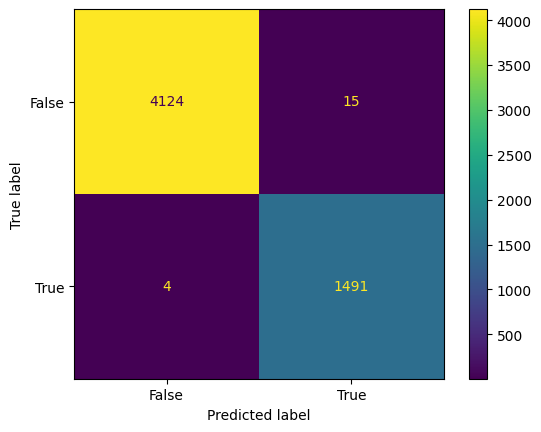

In [10]:
ConfusionMatrixDisplay.from_estimator(
        model_rf,
        X_train,
        y_train,
        display_labels=model_rf.classes_
    )

## 2.2 Cross-Validation and Hyperparameter Tuning

In [11]:
def perform_grid_search_rf(X_train_data, y_train_data, param_grid):
    """
    Performs GridSearchCV to find the best hyperparameters for a Random Forest model.
    Returns training and validation scores for the best model.

    Args:
        X_train_data (pd.DataFrame): Training features (unscaled).
        y_train_data (pd.Series): Training labels.
        param_grid (dict): Dictionary with hyperparameters.

    Returns:
        sklearn.ensemble.RandomForestClassifier: The best model found by GridSearchCV.
        dict: The best hyperparameters.
        float: The best cross-validation score (validation score).
        float: The corresponding training score for the best model.
    """
    
    # Initialize the model
    random_forest_model = RandomForestClassifier(random_state=42, 
                                      class_weight='balanced')
    
    
    grid_search = GridSearchCV(
        estimator=random_forest_model,
        param_grid=param_grid, 
        cv=5, 
        scoring='recall', 
        return_train_score=True,
        n_jobs=-1
    )
    
    # Fit the grid search
    grid_search.fit(X_train_data, y_train_data)
    
    
    # Get the scores for the best model
    best_model_index = grid_search.best_index_
    best_train_score = grid_search.cv_results_['mean_train_score'][best_model_index]
    
    return grid_search.best_estimator_, grid_search.best_params_, grid_search.best_score_, best_train_score

In [12]:
# Hyperparameter Grid Definition for Random Forest
param_grid_rf = {
    'n_estimators': [100, 150],
    'max_depth': [8, 10, 12],
    'min_samples_leaf': [15, 20],
    'min_samples_split': [15, 20]
}

print("Starting GridSearchCV for Random Forest (this may take a while)...")

# Call the Grid Search Function 
best_model_rf, best_hyperparams_rf, best_validation_score_rf, best_train_score_rf = perform_grid_search_rf(
    X_train, y_train, param_grid_rf
)

# Results Analysis
print("\n--- Random Forest Results ---")
print(f"Best Hyperparameters: {best_hyperparams_rf}")
print(f"Best Validation Recall (CV): {best_validation_score_rf:.4f}")
print(f"Training Recall (for the best model): {best_train_score_rf:.4f}")

Starting GridSearchCV for Random Forest (this may take a while)...

--- Random Forest Results ---
Best Hyperparameters: {'max_depth': 8, 'min_samples_leaf': 20, 'min_samples_split': 15, 'n_estimators': 150}
Best Validation Recall (CV): 0.7913
Training Recall (for the best model): 0.8264


In [13]:
# Optimal Model Evaluation
preditiva.calcula_desempenho(best_model_rf, X_train, y_train, X_test, y_test)

,Treino,Teste,Variação
Acurácia,0.775648,0.756565,-0.02
AUROC,0.874040,0.840533,-0.04
KS,0.590920,0.537743,-0.09
Precision,0.551129,0.528972,-0.04
Recall,0.832776,0.756684,-0.09
F1,0.747537,0.721494,-0.03


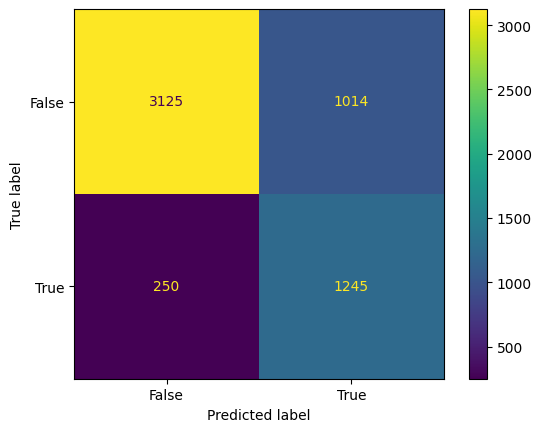

In [14]:
ConfusionMatrixDisplay.from_estimator(
        best_model_rf,
        X_train,
        y_train,
        display_labels=best_model_rf.classes_
    )

# 3. Churn Predict Test

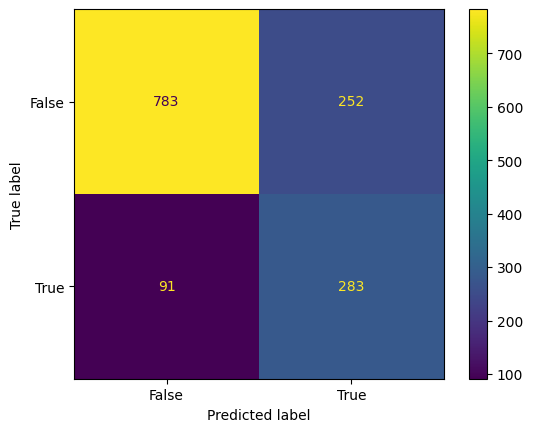

In [15]:
ConfusionMatrixDisplay.from_estimator(
        best_model_rf,
        X_test,
        y_test  ,
        display_labels=best_model_rf.classes_
    )

In [16]:
# Make the predictions and probabilities in X_test using the best model found.
previsoes_finais = best_model_rf.predict(X_test)
probabilidades = best_model_rf.predict_proba(X_test)
probabilidade_churn = probabilidades[:, 1]
print("Predictions and probabilities generated for the test base..")


Predictions and probabilities generated for the test base..


In [17]:
# Create the Results DataFrame
df_resultados = X_test.copy()
df_resultados['Real_Churn'] = y_test
df_resultados['Predict_Churn'] = previsoes_finais
df_resultados['Churn_Probability'] = probabilidade_churn
df_resultados['Churn_Probability'] = df_resultados['Churn_Probability'].round(4)

print("\nResults DataFrame created.")



Results DataFrame created.


In [18]:
df_resultados.head(50)

,tenure,MonthlyCharges,TotalCharges,Partner_Yes,Dependents_Yes,InternetService_Fiber optic,InternetService_No,OnlineSecurity_No internet service,OnlineSecurity_Yes,OnlineBackup_No internet service,...,StreamingMovies_Yes,Contract_One year,Contract_Two year,PaperlessBilling_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,Real_Churn,Predict_Churn,Churn_Probability
395,69,106.35,7261.75,True,True,True,False,False,True,False,...,True,False,True,True,True,False,False,False,False,0.1973
2537,6,80.80,457.10,True,False,True,False,False,False,False,...,False,False,False,True,False,True,False,False,True,0.8466
2485,51,81.15,4126.20,False,False,False,False,False,True,False,...,False,True,False,True,True,False,False,False,False,0.1892
4817,67,49.35,3321.35,False,False,False,False,False,True,False,...,False,True,False,True,False,False,False,False,False,0.1520
4155,56,59.80,3457.45,True,True,False,False,False,True,False,...,False,False,True,True,False,False,False,False,False,0.0839
6003,47,20.55,1013.05,False,True,False,True,True,False,True,...,False,True,False,False,True,False,False,False,False,0.0300
3996,52,63.25,3342.45,False,False,False,False,False,True,False,...,False,False,True,True,True,False,False,False,False,0.1132
3389,13,71.95,923.85,False,False,False,False,False,True,False,...,True,False,False,True,False,True,False,False,True,0.5567
6151,58,20.30,1131.50,False,False,False,True,True,False,True,...,False,False,True,False,True,False,False,False,False,0.0150
1338,9,94.75,889.90,False,False,True,False,False,False,False,...,True,False,False,True,False,True,False,True,True,0.8565


In [19]:
from sklearn.metrics import classification_report

print("\n--- Random Forest (no Scaler) Results ---")
y_pred_rf = best_model_rf.predict(X_test)
print(classification_report(y_test, y_pred_rf))


--- Random Forest (no Scaler) Results ---
              precision    recall  f1-score   support

       False       0.90      0.76      0.82      1035
        True       0.53      0.76      0.62       374

    accuracy                           0.76      1409
   macro avg       0.71      0.76      0.72      1409
weighted avg       0.80      0.76      0.77      1409

